In [1]:
import sys
sys.path.append('../code/')

In [29]:
from utils import *
from model import *
from config.config import config
import augmentations as ag
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
import timm

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


In [3]:
transform = ag.Compose([
                    ag.OneOf([
                        ag.GaussianNoiseSNR(min_snr=10, max_snr=20.0, p=1.),#this is the change
                        ag.PinkNoiseSNR(min_snr=10, max_snr=20.0, p=1.)#
                    ])
                    ])

In [11]:
main_df = pd.read_csv('../data/ff1010bird/ff1010bird_metadata_2018.csv')
path = '../data/'

train_dataset =  binarybird_dataset(main_df,augmentation=transform,path=path,effective_sec=5,aug_per=0.8,is_validation=False,)

train_dataloader = data.DataLoader(
            train_dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=True,
            num_workers=config.WORKERS,
            drop_last=True,
            pin_memory=True,
            
        )

model = BirdBinaryModel()
model.cuda()
model = model.train()

In [5]:
main_df.head()

,itemid,datasetid,hasbird
0,64486,ff1010bird,0
1,2525,ff1010bird,0
2,44981,ff1010bird,0
3,101323,ff1010bird,0
4,165746,ff1010bird,0


In [27]:
for data_t in train_dataloader:
    X = data_t['waveform'].cuda()
    input_viz = model.input_viz(X)
    input_viz = nn.BatchNorm2d(3).cuda()(input_viz)
    break

In [9]:
data_t['waveform'].shape

torch.Size([8, 441000])

In [28]:
print(input_viz.shape)
print(input_viz.min())
print(input_viz.max())

torch.Size([8, 3, 128, 862])
tensor(-7.0626, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3369, device='cuda:0', grad_fn=<MaxBackward1>)


In [17]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [23]:
input_viz[0,0,:,:].shape

torch.Size([128, 862])

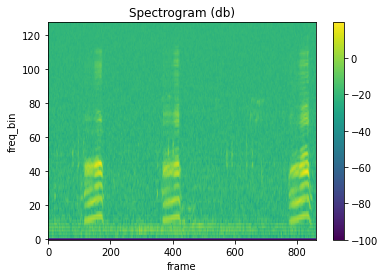

In [24]:
plot_spectrogram(input_viz[0,0,:,:].cpu(),)

## lets check timm

In [30]:
model_names = timm.list_models('eff*')
print(model_names)

['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b2a', 'efficientnet_b3', 'efficientnet_b3_pruned', 'efficientnet_b3a', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_b8', 'efficientnet_cc_b0_4e', 'efficientnet_cc_b0_8e', 'efficientnet_cc_b1_8e', 'efficientnet_el', 'efficientnet_el_pruned', 'efficientnet_em', 'efficientnet_es', 'efficientnet_es_pruned', 'efficientnet_l2', 'efficientnet_lite0', 'efficientnet_lite1', 'efficientnet_lite2', 'efficientnet_lite3', 'efficientnet_lite4', 'efficientnetv2_l', 'efficientnetv2_m', 'efficientnetv2_rw_m', 'efficientnetv2_rw_s', 'efficientnetv2_rw_t', 'efficientnetv2_s', 'efficientnetv2_xl']


In [31]:
m = timm.create_model('efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [33]:
print('the list ',list(m.children()))

the list  [Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), SiLU(inplace=True), Sequential(
  (0): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (se): SqueezeExcite(
        (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (act1): SiLU(inplace=True)
        (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (gate): Sigmoid()
      )
      (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
  )
  (1): Sequential(
    (0): InvertedResidual(
      (conv_pw): Conv

In [34]:
layers = list(m.children())[:-2]
model = nn.Sequential(*layers)

In [35]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): 